In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Télécharger les données

In [2]:
data_frame=pd.read_csv("/home/onyxia/work/NLP_3A_ENSAE/data_bases/data_cleaned.csv",sep=",")

In [3]:
data_frame.head()

,Unnamed: 0,sex,first_name,surname
0,0,femme,Marie,Chardon
1,1,homme,Louis,Lhopital
2,2,femme,Marie,Pyrin
3,3,femme,Marie,Lavocat
4,4,femme,Marguerite,Benne


In [4]:
texts = data_frame['first_name'].tolist()
labels = data_frame['sex'].tolist()


# Télécharger le modèle de Hagging face et manipulation des données pour le fine tuning

In [5]:
model_name = "padmajabfrl/Gender-Classification"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

## Je split les données en training et testing

In [6]:

train_texts, test_texts, train_labels,test_labels = train_test_split(texts, labels, test_size=.2)



In [7]:
# Je transforme mes données de façon à ce que les femmes soient encodées en 1 et les hommes en 0
label_map = {'homme': 0, 'femme': 1}  
train_labels = [label_map[label] for label in train_labels]
test_labels = [label_map[label] for label in test_labels]

Turn the data to Dataset

In [8]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label)
        }

    def __len__(self):
        return len(self.labels)


train_dataset = IMDbDataset(train_texts, train_labels, tokenizer, max_length=128)
test_dataset = IMDbDataset(test_texts, test_labels, tokenizer, max_length=128)


In [10]:
class GenderClassifier:
    def __init__(self, model_name='padmajabfrl/Gender-Classification'):
        self.model = DistilBertForSequenceClassification.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.accuracy=0
        self.recall_acc=0

    def train(self, train_dataset, num_epochs=10, batch_size=16, learning_rate=5e-5):
        self.model.to(self.device)
        self.model.train()
        optimizer = torch.optim.AdamW (self.model.parameters(), lr=learning_rate)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(num_epochs):
            total_loss = 0
            for batch in train_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            average_loss = total_loss / len(train_loader)
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}')

        self.model.eval()

    def predict(self, input_text):
        inputs = self.tokenizer(input_text, return_tensors='pt')
        inputs = {key: val.to(self.device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)

        predictions = torch.argmax(outputs.logits, dim=1).item()
        label_map = {0: 'homme', 1: 'femme'}
        predicted_label = label_map[predictions]

        return predicted_label
    
    def evaluate(self,test_dataset, batch_size=16,conf_matrix=False,Roc_curve=False,pr_curve=False):
        self.model.eval()
        all_probs = []
        true_labels = []
        predicted_labels = []
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        for batch in test_loader:
            input_ids = batch['input_ids'].to(classifier.device)
            attention_mask = batch['attention_mask'].to(classifier.device)
            labels = batch['labels']

            with torch.no_grad():
                outputs = classifier.model(input_ids, attention_mask=attention_mask)

            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()


            # Metrics calculation for visualization
            if Roc_curve or pr_curve:
                probs = torch.softmax(outputs.logits, dim=1)
                all_probs.extend(probs[:, 1].cpu().numpy())
                


            true_labels.extend(labels)
            predicted_labels.extend(predictions)
        true_labels = np.array(true_labels)

        predicted_labels = np.array(predicted_labels)
        accuracy = accuracy_score(true_labels, predicted_labels)
        self.accuracy=accuracy
        report = classification_report(true_labels, predicted_labels)
        print(f"The model's accuracy on the testing dataset is: {accuracy}. \n The model's performance report on the testing dataset is the following :\n {report}")

        # Plotting some intersting metrics about the classifier

        #Confucion matrix

        if conf_matrix:
          print("Find bellow the Confusion Matrix")
          conf_matrix = confusion_matrix(true_labels, predicted_labels)
          sns.heatmap(conf_matrix, fmt='d', cmap='BuPu', annot=True)
          plt.imshow(conf_matrix, cmap='BuPu', interpolation='nearest')
          plt.title('Confusion Matrix')
          plt.xlabel('Predicted Label')
          plt.ylabel('True Label')
          plt.xticks([0, 1], ['homme', 'femme'])
          plt.yticks([0, 1], ['homme', 'femme'])
          plt.show()

        
        #ROC Curve

        if Roc_curve:
            print("Find bellow the ROC Curve")
            fpr, tpr, _ = roc_curve(true_labels, all_probs)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc="lower right")
            plt.show()

        
        #Precision-Recall Curve

        if pr_curve:
            print("Find bellow the Precision-Recall Curve")
            precision, recall, _ = precision_recall_curve(true_labels, all_probs)
            pr_auc = auc(recall, precision)
            self.recall_acc=pr_auc
            plt.figure()
            plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.legend(loc="lower left")
            plt.show()


In [12]:
# Training
classifier = GenderClassifier()
classifier.train(train_dataset,num_epochs=20)  

Epoch 1/20, Loss: 0.4572
Epoch 2/20, Loss: 0.2270
Epoch 3/20, Loss: 0.0751
Epoch 4/20, Loss: 0.0603
Epoch 5/20, Loss: 0.0414
Epoch 6/20, Loss: 0.0357
Epoch 7/20, Loss: 0.0392
Epoch 8/20, Loss: 0.0306
Epoch 9/20, Loss: 0.0273
Epoch 10/20, Loss: 0.0250
Epoch 11/20, Loss: 0.0260
Epoch 12/20, Loss: 0.0251
Epoch 13/20, Loss: 0.0232
Epoch 14/20, Loss: 0.0404
Epoch 15/20, Loss: 0.0339
Epoch 16/20, Loss: 0.0203
Epoch 17/20, Loss: 0.0222
Epoch 18/20, Loss: 0.0255
Epoch 19/20, Loss: 0.0219
Epoch 20/20, Loss: 0.0239


In [13]:
# Prediction
prediction = classifier.predict("Francoise")
print(f'Predicted label: {prediction}')

Predicted label: femme


The model's accuracy on the testing dataset is: 0.9361702127659575. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.93      0.96      0.94        26

    accuracy                           0.94        47
   macro avg       0.94      0.93      0.94        47
weighted avg       0.94      0.94      0.94        47

Find bellow the Confusion Matrix


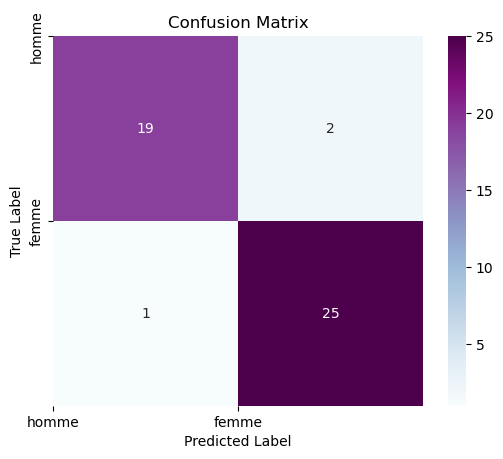

Find bellow the ROC Curve


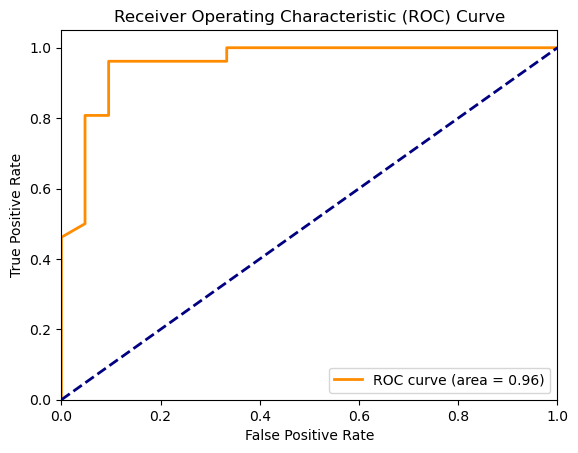

Find bellow the Precision-Recall Curve


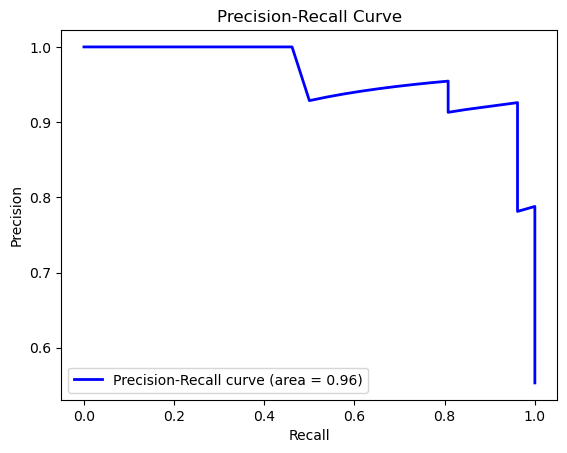

In [14]:
classifier.evaluate(test_dataset,conf_matrix=True,Roc_curve=True,pr_curve=True)

# Tester la stabilité du modèle

Epoch 1/15, Loss: 0.4024
Epoch 2/15, Loss: 0.1705
Epoch 3/15, Loss: 0.0731
Epoch 4/15, Loss: 0.0275
Epoch 5/15, Loss: 0.0092
Epoch 6/15, Loss: 0.0064
Epoch 7/15, Loss: 0.0013
Epoch 8/15, Loss: 0.0012
Epoch 9/15, Loss: 0.0010
Epoch 10/15, Loss: 0.0006
Epoch 11/15, Loss: 0.0003
Epoch 12/15, Loss: 0.0003
Epoch 13/15, Loss: 0.0003
Epoch 14/15, Loss: 0.0003
Epoch 15/15, Loss: 0.0003
The model's accuracy on the testing dataset is: 0.9148936170212766. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       1.00      0.84      0.91        25
           1       0.85      1.00      0.92        22

    accuracy                           0.91        47
   macro avg       0.92      0.92      0.91        47
weighted avg       0.93      0.91      0.91        47

Find bellow the Precision-Recall Curve


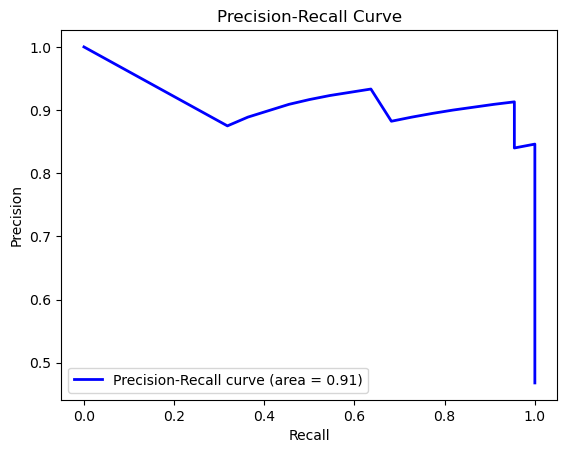

Epoch 1/15, Loss: 0.5880
Epoch 2/15, Loss: 0.2427
Epoch 3/15, Loss: 0.1099
Epoch 4/15, Loss: 0.0753
Epoch 5/15, Loss: 0.0539
Epoch 6/15, Loss: 0.0517
Epoch 7/15, Loss: 0.0450
Epoch 8/15, Loss: 0.0502
Epoch 9/15, Loss: 0.0438
Epoch 10/15, Loss: 0.0398
Epoch 11/15, Loss: 0.0385
Epoch 12/15, Loss: 0.0425
Epoch 13/15, Loss: 0.0496
Epoch 14/15, Loss: 0.0384
Epoch 15/15, Loss: 0.0411
The model's accuracy on the testing dataset is: 0.9148936170212766. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        26
           1       0.90      0.90      0.90        21

    accuracy                           0.91        47
   macro avg       0.91      0.91      0.91        47
weighted avg       0.91      0.91      0.91        47

Find bellow the Precision-Recall Curve


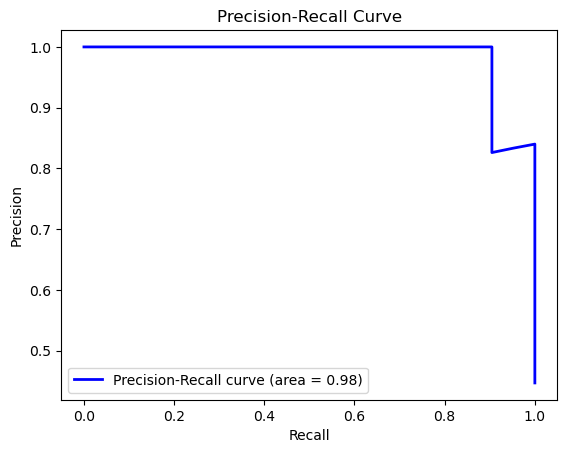

Epoch 1/15, Loss: 0.6497
Epoch 2/15, Loss: 0.2468
Epoch 3/15, Loss: 0.1112
Epoch 4/15, Loss: 0.1068
Epoch 5/15, Loss: 0.0807
Epoch 6/15, Loss: 0.0600
Epoch 7/15, Loss: 0.0502
Epoch 8/15, Loss: 0.0562
Epoch 9/15, Loss: 0.0395
Epoch 10/15, Loss: 0.0325
Epoch 11/15, Loss: 0.0361
Epoch 12/15, Loss: 0.0315
Epoch 13/15, Loss: 0.0433
Epoch 14/15, Loss: 0.0344
Epoch 15/15, Loss: 0.0327
The model's accuracy on the testing dataset is: 0.9574468085106383. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.92      1.00      0.96        24

    accuracy                           0.96        47
   macro avg       0.96      0.96      0.96        47
weighted avg       0.96      0.96      0.96        47

Find bellow the Precision-Recall Curve


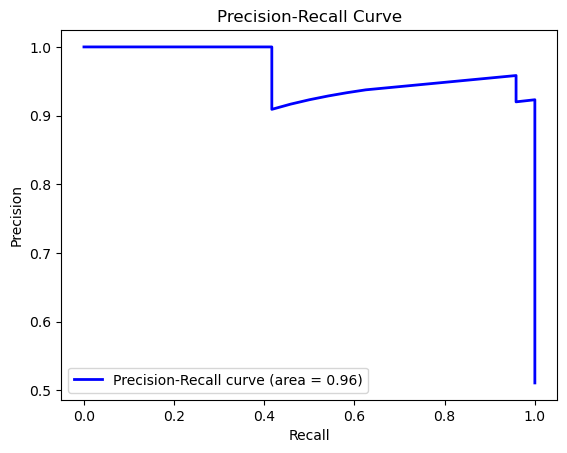

Epoch 1/15, Loss: 0.5324
Epoch 2/15, Loss: 0.2364
Epoch 3/15, Loss: 0.1482
Epoch 4/15, Loss: 0.0703
Epoch 5/15, Loss: 0.1004
Epoch 6/15, Loss: 0.0594
Epoch 7/15, Loss: 0.0459
Epoch 8/15, Loss: 0.0398
Epoch 9/15, Loss: 0.0396
Epoch 10/15, Loss: 0.0350
Epoch 11/15, Loss: 0.0387
Epoch 12/15, Loss: 0.0474
Epoch 13/15, Loss: 0.0372
Epoch 14/15, Loss: 0.0471
Epoch 15/15, Loss: 0.0425
The model's accuracy on the testing dataset is: 0.9148936170212766. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       0.87      0.95      0.91        21
           1       0.96      0.88      0.92        26

    accuracy                           0.91        47
   macro avg       0.91      0.92      0.91        47
weighted avg       0.92      0.91      0.92        47

Find bellow the Precision-Recall Curve


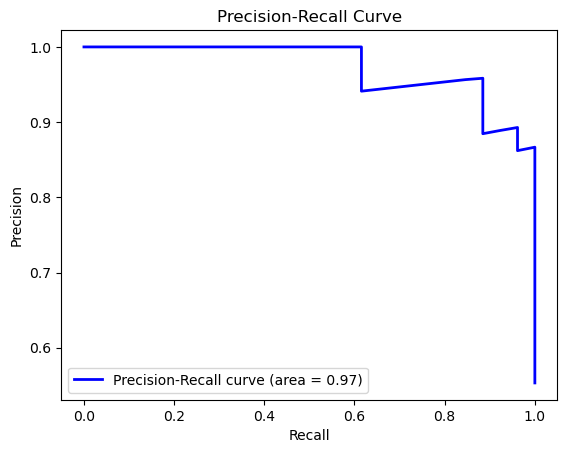

Epoch 1/15, Loss: 0.3966
Epoch 2/15, Loss: 0.1284
Epoch 3/15, Loss: 0.0723
Epoch 4/15, Loss: 0.0572
Epoch 5/15, Loss: 0.1037
Epoch 6/15, Loss: 0.0575
Epoch 7/15, Loss: 0.0443
Epoch 8/15, Loss: 0.0481
Epoch 9/15, Loss: 0.0449
Epoch 10/15, Loss: 0.0470
Epoch 11/15, Loss: 0.0448
Epoch 12/15, Loss: 0.0459
Epoch 13/15, Loss: 0.0429
Epoch 14/15, Loss: 0.0370
Epoch 15/15, Loss: 0.0494
The model's accuracy on the testing dataset is: 0.9574468085106383. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        30
           1       1.00      0.88      0.94        17

    accuracy                           0.96        47
   macro avg       0.97      0.94      0.95        47
weighted avg       0.96      0.96      0.96        47

Find bellow the Precision-Recall Curve


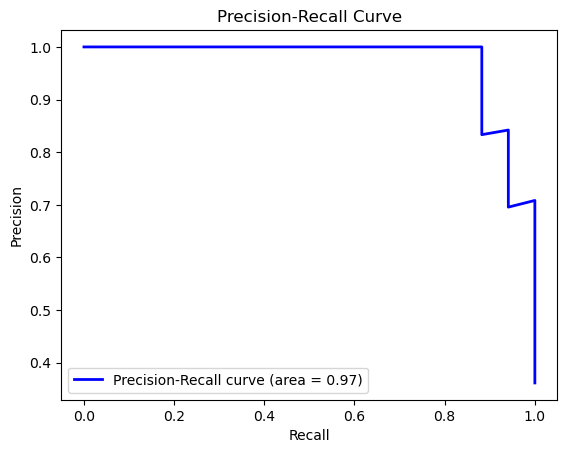

Epoch 1/15, Loss: 0.6509
Epoch 2/15, Loss: 0.1699
Epoch 3/15, Loss: 0.1135
Epoch 4/15, Loss: 0.0669
Epoch 5/15, Loss: 0.0502
Epoch 6/15, Loss: 0.0431
Epoch 7/15, Loss: 0.0486
Epoch 8/15, Loss: 0.0740
Epoch 9/15, Loss: 0.0388
Epoch 10/15, Loss: 0.0433
Epoch 11/15, Loss: 0.0376
Epoch 12/15, Loss: 0.0550
Epoch 13/15, Loss: 0.0447
Epoch 14/15, Loss: 0.0356
Epoch 15/15, Loss: 0.0513
The model's accuracy on the testing dataset is: 0.9361702127659575. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       1.00      0.88      0.94        25
           1       0.88      1.00      0.94        22

    accuracy                           0.94        47
   macro avg       0.94      0.94      0.94        47
weighted avg       0.94      0.94      0.94        47

Find bellow the Precision-Recall Curve


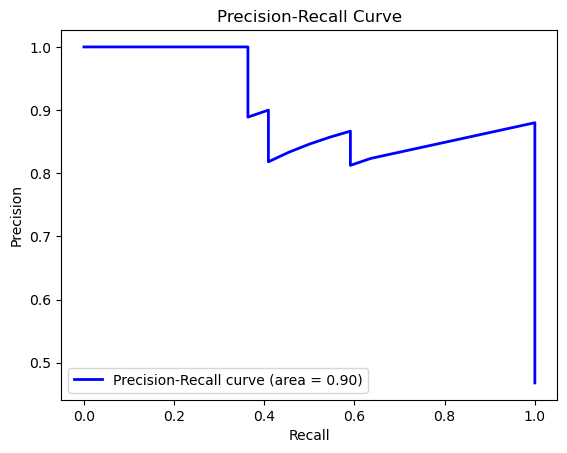

Epoch 1/15, Loss: 0.4415
Epoch 2/15, Loss: 0.1887
Epoch 3/15, Loss: 0.1086
Epoch 4/15, Loss: 0.0869
Epoch 5/15, Loss: 0.0725
Epoch 6/15, Loss: 0.0705
Epoch 7/15, Loss: 0.0753
Epoch 8/15, Loss: 0.0688
Epoch 9/15, Loss: 0.0707
Epoch 10/15, Loss: 0.0554
Epoch 11/15, Loss: 0.0491
Epoch 12/15, Loss: 0.0405
Epoch 13/15, Loss: 0.0381
Epoch 14/15, Loss: 0.0429
Epoch 15/15, Loss: 0.0395
The model's accuracy on the testing dataset is: 0.9574468085106383. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       1.00      0.93      0.96        29
           1       0.90      1.00      0.95        18

    accuracy                           0.96        47
   macro avg       0.95      0.97      0.96        47
weighted avg       0.96      0.96      0.96        47

Find bellow the Precision-Recall Curve


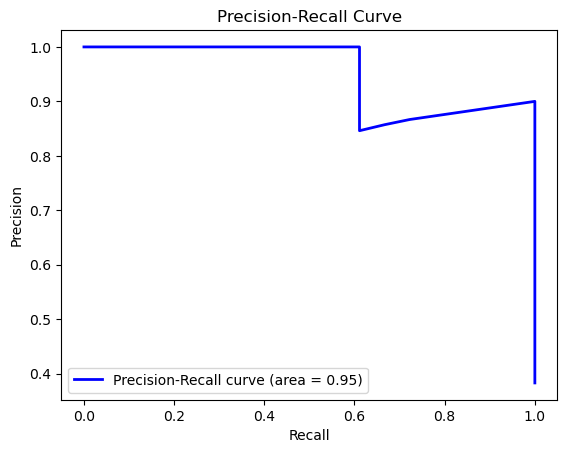

Epoch 1/15, Loss: 0.7867
Epoch 2/15, Loss: 0.2323
Epoch 3/15, Loss: 0.1581
Epoch 4/15, Loss: 0.1155
Epoch 5/15, Loss: 0.1032
Epoch 6/15, Loss: 0.0715
Epoch 7/15, Loss: 0.0716
Epoch 8/15, Loss: 0.0548
Epoch 9/15, Loss: 0.0630
Epoch 10/15, Loss: 0.0609
Epoch 11/15, Loss: 0.0526
Epoch 12/15, Loss: 0.0459
Epoch 13/15, Loss: 0.0391
Epoch 14/15, Loss: 0.0373
Epoch 15/15, Loss: 0.0410
The model's accuracy on the testing dataset is: 1.0. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        18

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47

Find bellow the Precision-Recall Curve


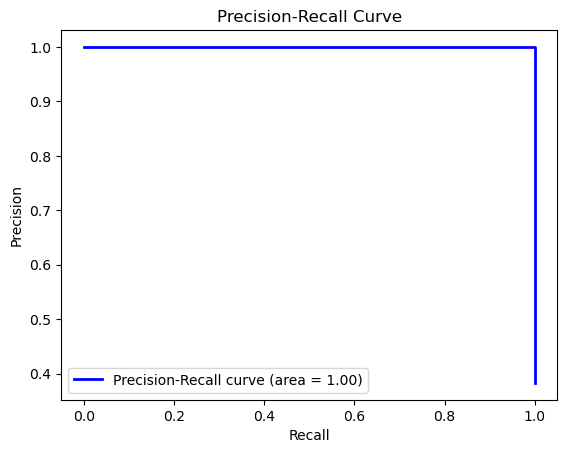

Epoch 1/15, Loss: 0.4579
Epoch 2/15, Loss: 0.1748
Epoch 3/15, Loss: 0.0774
Epoch 4/15, Loss: 0.0564
Epoch 5/15, Loss: 0.0388
Epoch 6/15, Loss: 0.0419
Epoch 7/15, Loss: 0.0397
Epoch 8/15, Loss: 0.0472
Epoch 9/15, Loss: 0.0537
Epoch 10/15, Loss: 0.0787
Epoch 11/15, Loss: 0.0575
Epoch 12/15, Loss: 0.0415
Epoch 13/15, Loss: 0.0496
Epoch 14/15, Loss: 0.0362
Epoch 15/15, Loss: 0.0379
The model's accuracy on the testing dataset is: 0.9361702127659575. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       1.00      0.88      0.94        25
           1       0.88      1.00      0.94        22

    accuracy                           0.94        47
   macro avg       0.94      0.94      0.94        47
weighted avg       0.94      0.94      0.94        47

Find bellow the Precision-Recall Curve


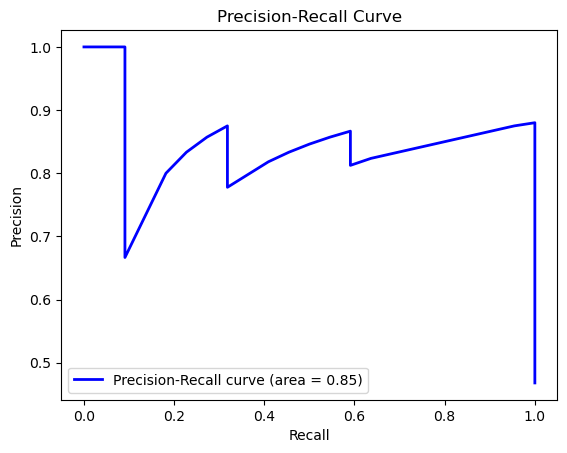

Epoch 1/15, Loss: 0.5013
Epoch 2/15, Loss: 0.2105
Epoch 3/15, Loss: 0.1472
Epoch 4/15, Loss: 0.0811
Epoch 5/15, Loss: 0.0833
Epoch 6/15, Loss: 0.0697
Epoch 7/15, Loss: 0.0565
Epoch 8/15, Loss: 0.0511
Epoch 9/15, Loss: 0.0433
Epoch 10/15, Loss: 0.0415
Epoch 11/15, Loss: 0.0362
Epoch 12/15, Loss: 0.0570
Epoch 13/15, Loss: 0.0389
Epoch 14/15, Loss: 0.0432
Epoch 15/15, Loss: 0.0671
The model's accuracy on the testing dataset is: 0.9787234042553191. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      0.96      0.98        25

    accuracy                           0.98        47
   macro avg       0.98      0.98      0.98        47
weighted avg       0.98      0.98      0.98        47

Find bellow the Precision-Recall Curve


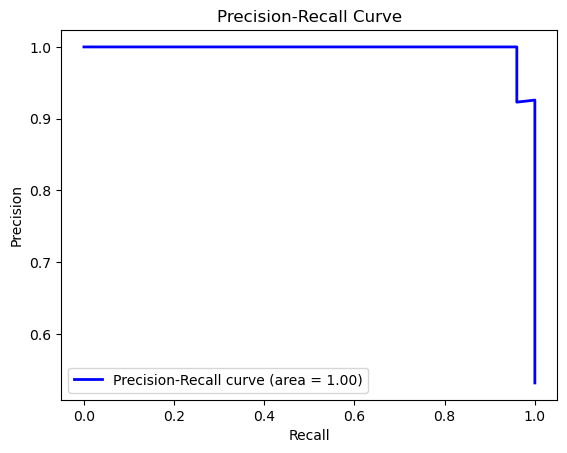

In [16]:
acc=[]
recall_acc=[]
for k in range(10):
    train_texts, test_texts, train_labels,test_labels = train_test_split(texts, labels, test_size=0.2)
    label_map = {'homme': 0, 'femme': 1}  
    train_labels = [label_map[label] for label in train_labels]
    test_labels = [label_map[label] for label in test_labels]
    train_dataset = IMDbDataset(train_texts, train_labels, tokenizer, max_length=128)
    test_dataset = IMDbDataset(test_texts, test_labels, tokenizer, max_length=128)
    classifier = GenderClassifier()
    classifier.train(train_dataset,num_epochs=15)  
    classifier.evaluate(test_dataset,conf_matrix=False,Roc_curve=False,pr_curve=True)
    acc.append(classifier.accuracy)
    recall_acc.append(classifier.recall_acc)

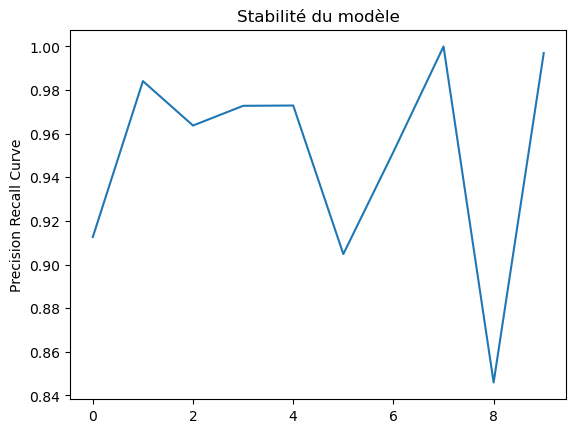

In [18]:
plt.plot(recall_acc)
plt.title('Stabilité du modèle')
plt.ylabel('Precision Recall Curve')
plt.show()

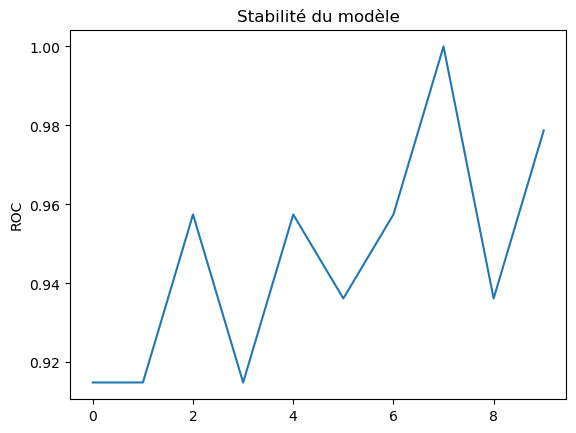

In [20]:
plt.plot(acc)
plt.title('Stabilité du modèle')
plt.ylabel('ROC')
plt.show()